<img src="http://hauteliving.com/wp-content/uploads/2012/03/lc.jpg">

### This jupyter notebook aims to build a baseline model for restaurant visitor count forecast problem using Decision Tree Regressor, ensemble methods like Bagging Decision Tree Regressor, Random Forest Regressor

In [1]:
#Load train, test data to dataFrames
%matplotlib inline
import pandas as pd
import numpy as np
import re
import warnings
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.dates as dates
import seaborn as sns
plt.style.use('ggplot')
warnings.simplefilter("ignore")
df_train = pd.read_csv(".//Data//Train_data.csv")
df_test = pd.read_csv(".//Data//Test_data.csv")
df_date_info = pd.read_csv('.//Data//date_info.csv')

df_date_info.calendar_date = pd.to_datetime(df_date_info.calendar_date)
#change the index of df_date_info to calendar_date
df_date_info = df_date_info.set_index('calendar_date')
df_train['holiday_flg'] = df_train['visit_date'].apply(lambda x : df_date_info.loc[x]['holiday_flg'])
df_test['holiday_flg'] = df_test['visit_date'].apply(lambda x : df_date_info.loc[x]['holiday_flg'])

In [2]:
df_train.head(5)

,air_store_id,visit_date,visitors,dow,year,month,mean_visitors,max_visitors,min_visitors,median_visitors,air_genre_name,air_area_name,latitude,longitude,reserve_visitors,reserve_datetime_diff,holiday_flg
0,air_ba937bf13d40fb24,1/13/2016,25,2,2016,1,23.843750,57,7,25.0,Dining bar,T?ky?-to Minato-ku Shibak?en,35.658068,139.751599,0,0,0
1,air_ba937bf13d40fb24,1/14/2016,32,3,2016,1,20.292308,54,2,21.0,Dining bar,T?ky?-to Minato-ku Shibak?en,35.658068,139.751599,0,0,0
2,air_ba937bf13d40fb24,1/15/2016,29,4,2016,1,34.738462,61,4,35.0,Dining bar,T?ky?-to Minato-ku Shibak?en,35.658068,139.751599,0,0,0
3,air_ba937bf13d40fb24,1/16/2016,22,5,2016,1,27.651515,53,6,27.0,Dining bar,T?ky?-to Minato-ku Shibak?en,35.658068,139.751599,0,0,0
4,air_ba937bf13d40fb24,1/18/2016,6,0,2016,1,13.754386,34,2,12.0,Dining bar,T?ky?-to Minato-ku Shibak?en,35.658068,139.751599,0,0,0


In [3]:
df_test.head(5)


,id,visitors,visit_date,air_store_id,dow,year,month,mean_visitors,max_visitors,min_visitors,median_visitors,air_genre_name,air_area_name,latitude,longitude,reserve_visitors,reserve_datetime_diff,holiday_flg
0,air_00a91d42b08b08d9_2017-04-23,0,4/23/2017,air_00a91d42b08b08d9,6,2017,4,2.000000,2,2,2.0,Italian/French,T?ky?-to Chiyoda-ku Kudanminami,35.694003,139.753595,0,-2,0
1,air_00a91d42b08b08d9_2017-04-24,0,4/24/2017,air_00a91d42b08b08d9,0,2017,4,22.457143,47,1,19.0,Italian/French,T?ky?-to Chiyoda-ku Kudanminami,35.694003,139.753595,0,-2,0
2,air_00a91d42b08b08d9_2017-04-25,0,4/25/2017,air_00a91d42b08b08d9,1,2017,4,24.350000,43,1,24.5,Italian/French,T?ky?-to Chiyoda-ku Kudanminami,35.694003,139.753595,0,-2,0
3,air_00a91d42b08b08d9_2017-04-26,0,4/26/2017,air_00a91d42b08b08d9,2,2017,4,28.125000,52,15,28.0,Italian/French,T?ky?-to Chiyoda-ku Kudanminami,35.694003,139.753595,0,-2,0
4,air_00a91d42b08b08d9_2017-04-27,0,4/27/2017,air_00a91d42b08b08d9,3,2017,4,29.868421,47,15,30.0,Italian/French,T?ky?-to Chiyoda-ku Kudanminami,35.694003,139.753595,0,-2,0


##### Change the columns to their respective types
#####   air_area_name =====> categorical type
#####   air_genre_name ===> categorical type 

In [4]:
#Change latitude,longitude type to float type
df_train['air_genre_name'] = df_train['air_genre_name'].apply(lambda x : 'Other' if x == '-1' else x)
df_test['air_genre_name'] = df_test['air_genre_name'].apply(lambda x : 'Other' if x == '-1' else x)

df_train['latitude'] = df_train['latitude'].convert_objects(convert_numeric=True)
df_train['longitude'] = df_train['longitude'].convert_objects(convert_numeric=True)

df_test['latitude'] = df_test['latitude'].convert_objects(convert_numeric=True)
df_test['longitude'] = df_test['longitude'].convert_objects(convert_numeric=True)

#change the air_genre_name,air_store_id to categorical type
df_train['air_area_name'] = df_train['air_area_name'].astype('category')
df_train['air_genre_name'] = df_train['air_genre_name'].astype('category')

df_test['air_area_name'] = df_test['air_area_name'].astype('category')
df_test['air_genre_name'] = df_test['air_genre_name'].astype('category')

### Location of restaurants with visitors

In [73]:
df = df_train.groupby(['latitude','longitude'])['visitors'].sum()

(array([   0.,   20.,   40.,   60.,   80.,  100.,  120.]),
 <a list of 7 Text xticklabel objects>)

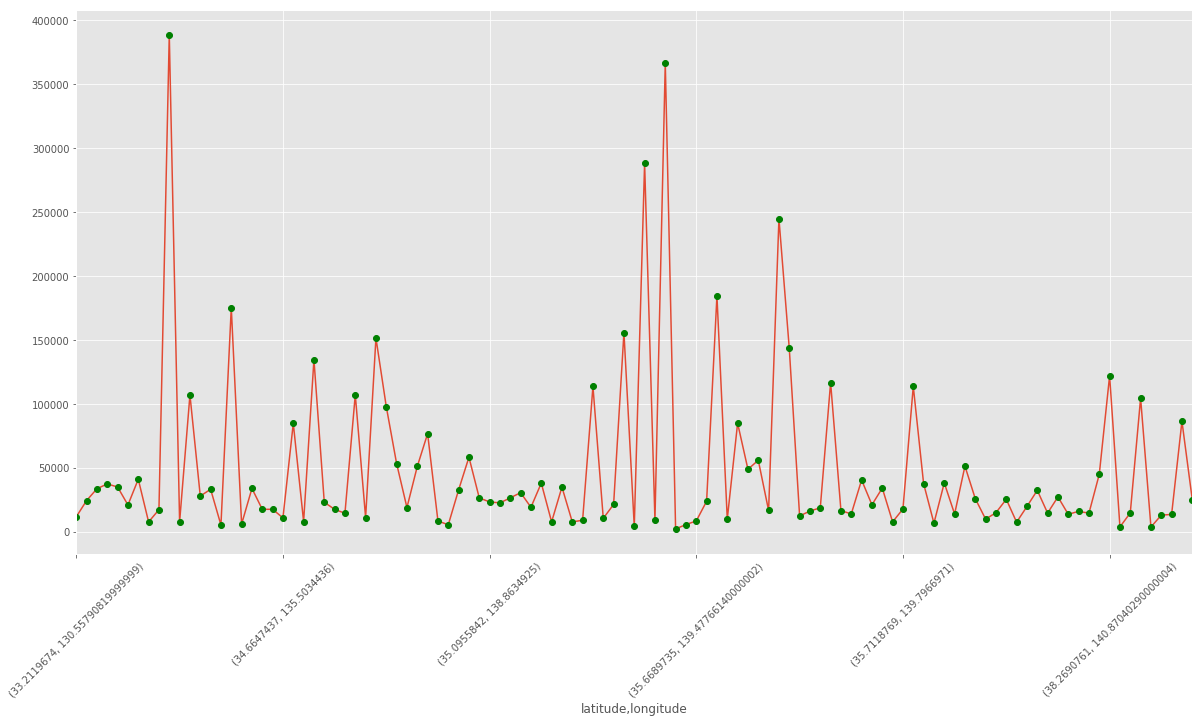

In [85]:
plt.figure(figsize=(20,10))
ax = df.plot()
df.reindex(df.index).plot(marker='o',linestyle='none',color='g', ax=ax)
plt.xticks(rotation=45)

In [5]:
df_train['visit_date'] = pd.to_datetime(df_train['visit_date'])
df_test['visit_date'] = pd.to_datetime(df_test['visit_date'])

df_train['day'] = df_train['visit_date'].dt.day
df_test['day'] = df_test['visit_date'].dt.day

df_train['fri'] = (df_train['dow'] == 4)*1
df_train['sat'] = (df_train['dow'] == 5)*1
df_train['sun'] = (df_train['dow'] == 6)*1

df_test['fri'] = (df_test['dow'] == 4)*1
df_test['sat'] = (df_test['dow'] == 5)*1
df_test['sun'] = (df_test['dow'] == 6)*1

In [6]:
len(df_train['air_genre_name'].unique())

14

In [7]:
from sklearn.preprocessing import LabelEncoder
le_train = LabelEncoder()
le_train.fit(df_train['air_store_id'].values)

LabelEncoder()

In [8]:
df_train['air_store_id'] = le_train.transform(df_train['air_store_id'].values)
df_test['air_store_id'] = le_train.transform(df_test['air_store_id'].values)

In [9]:
df_train.head()

,air_store_id,visit_date,visitors,dow,year,month,mean_visitors,max_visitors,min_visitors,median_visitors,...,air_area_name,latitude,longitude,reserve_visitors,reserve_datetime_diff,holiday_flg,day,fri,sat,sun
0,603,2016-01-13,25,2,2016,1,23.843750,57,7,25.0,...,T?ky?-to Minato-ku Shibak?en,35.658068,139.751599,0,0,0,13,0,0,0
1,603,2016-01-14,32,3,2016,1,20.292308,54,2,21.0,...,T?ky?-to Minato-ku Shibak?en,35.658068,139.751599,0,0,0,14,0,0,0
2,603,2016-01-15,29,4,2016,1,34.738462,61,4,35.0,...,T?ky?-to Minato-ku Shibak?en,35.658068,139.751599,0,0,0,15,1,0,0
3,603,2016-01-16,22,5,2016,1,27.651515,53,6,27.0,...,T?ky?-to Minato-ku Shibak?en,35.658068,139.751599,0,0,0,16,0,1,0
4,603,2016-01-18,6,0,2016,1,13.754386,34,2,12.0,...,T?ky?-to Minato-ku Shibak?en,35.658068,139.751599,0,0,0,18,0,0,0


In [10]:
df_test.head()

,id,visitors,visit_date,air_store_id,dow,year,month,mean_visitors,max_visitors,min_visitors,...,air_area_name,latitude,longitude,reserve_visitors,reserve_datetime_diff,holiday_flg,day,fri,sat,sun
0,air_00a91d42b08b08d9_2017-04-23,0,2017-04-23,0,6,2017,4,2.000000,2,2,...,T?ky?-to Chiyoda-ku Kudanminami,35.694003,139.753595,0,-2,0,23,0,0,1
1,air_00a91d42b08b08d9_2017-04-24,0,2017-04-24,0,0,2017,4,22.457143,47,1,...,T?ky?-to Chiyoda-ku Kudanminami,35.694003,139.753595,0,-2,0,24,0,0,0
2,air_00a91d42b08b08d9_2017-04-25,0,2017-04-25,0,1,2017,4,24.350000,43,1,...,T?ky?-to Chiyoda-ku Kudanminami,35.694003,139.753595,0,-2,0,25,0,0,0
3,air_00a91d42b08b08d9_2017-04-26,0,2017-04-26,0,2,2017,4,28.125000,52,15,...,T?ky?-to Chiyoda-ku Kudanminami,35.694003,139.753595,0,-2,0,26,0,0,0
4,air_00a91d42b08b08d9_2017-04-27,0,2017-04-27,0,3,2017,4,29.868421,47,15,...,T?ky?-to Chiyoda-ku Kudanminami,35.694003,139.753595,0,-2,0,27,0,0,0


In [11]:
df_train_with_dummies = pd.get_dummies(df_train.drop(['visit_date','air_store_id'],axis=1))
df_train_with_dummies.head()


,visitors,dow,year,month,mean_visitors,max_visitors,min_visitors,median_visitors,latitude,longitude,...,air_area_name_T?ky?-to Suginami-ku Asagayaminami,air_area_name_T?ky?-to Tachikawa-shi Izumich?,air_area_name_T?ky?-to Tait?-ku Asakusa,air_area_name_T?ky?-to Tait?-ku Higashiueno,air_area_name_T?ky?-to Tait?-ku Kuramae,air_area_name_T?ky?-to Toshima-ku Higashiikebukuro,air_area_name_T?ky?-to Toshima-ku Mejiro,air_area_name_T?ky?-to Toshima-ku Minamiikebukuro,air_area_name_T?ky?-to Toshima-ku Nishiikebukuro,air_area_name_T?ky?-to Toshima-ku Sugamo
0,25,2,2016,1,23.843750,57,7,25.0,35.658068,139.751599,...,0,0,0,0,0,0,0,0,0,0
1,32,3,2016,1,20.292308,54,2,21.0,35.658068,139.751599,...,0,0,0,0,0,0,0,0,0,0
2,29,4,2016,1,34.738462,61,4,35.0,35.658068,139.751599,...,0,0,0,0,0,0,0,0,0,0
3,22,5,2016,1,27.651515,53,6,27.0,35.658068,139.751599,...,0,0,0,0,0,0,0,0,0,0
4,6,0,2016,1,13.754386,34,2,12.0,35.658068,139.751599,...,0,0,0,0,0,0,0,0,0,0


In [12]:
df_test_with_dummies = pd.get_dummies(df_test.drop(['id','air_store_id','visit_date'],axis=1))
df_test_with_dummies.head()

,visitors,dow,year,month,mean_visitors,max_visitors,min_visitors,median_visitors,latitude,longitude,...,air_area_name_T?ky?-to Suginami-ku Asagayaminami,air_area_name_T?ky?-to Tachikawa-shi Izumich?,air_area_name_T?ky?-to Tait?-ku Asakusa,air_area_name_T?ky?-to Tait?-ku Higashiueno,air_area_name_T?ky?-to Tait?-ku Kuramae,air_area_name_T?ky?-to Toshima-ku Higashiikebukuro,air_area_name_T?ky?-to Toshima-ku Mejiro,air_area_name_T?ky?-to Toshima-ku Minamiikebukuro,air_area_name_T?ky?-to Toshima-ku Nishiikebukuro,air_area_name_T?ky?-to Toshima-ku Sugamo
0,0,6,2017,4,2.000000,2,2,2.0,35.694003,139.753595,...,0,0,0,0,0,0,0,0,0,0
1,0,0,2017,4,22.457143,47,1,19.0,35.694003,139.753595,...,0,0,0,0,0,0,0,0,0,0
2,0,1,2017,4,24.350000,43,1,24.5,35.694003,139.753595,...,0,0,0,0,0,0,0,0,0,0
3,0,2,2017,4,28.125000,52,15,28.0,35.694003,139.753595,...,0,0,0,0,0,0,0,0,0,0
4,0,3,2017,4,29.868421,47,15,30.0,35.694003,139.753595,...,0,0,0,0,0,0,0,0,0,0


In [13]:
y = np.log1p(df_train_with_dummies['visitors']).values
X = df_train_with_dummies.drop(['visitors','air_area_name_-1'],axis=1).values

#### Decision Tree Regressor

In [14]:
# Import regression modules
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [15]:
dtree = DecisionTreeRegressor().fit(X_train, y_train)
y_pred = dtree.predict(X_test)

In [16]:
from sklearn.metrics import mean_squared_error
#squared_error = ((y_pred + 1) - (y_test + 1)) ** 2
#rmsle = np.sqrt( np.sum(squared_error) / len(y_pred) )
rmse = np.sqrt(mean_squared_error(y_pred,y_test))
print("RMSE",rmse)
print(max(y_pred))
#print(y_pred)

RMSE 0.708478135079
6.77764659364


In [17]:
print("Training Accuracy : ",dtree.score(X_train,y_train))
print("Test Accuracy : ",dtree.score(X_test,y_test))

Training Accuracy :  0.996557083831
Test Accuracy :  0.232806475623


In [18]:
df_test_with_dummies.head()

,visitors,dow,year,month,mean_visitors,max_visitors,min_visitors,median_visitors,latitude,longitude,...,air_area_name_T?ky?-to Suginami-ku Asagayaminami,air_area_name_T?ky?-to Tachikawa-shi Izumich?,air_area_name_T?ky?-to Tait?-ku Asakusa,air_area_name_T?ky?-to Tait?-ku Higashiueno,air_area_name_T?ky?-to Tait?-ku Kuramae,air_area_name_T?ky?-to Toshima-ku Higashiikebukuro,air_area_name_T?ky?-to Toshima-ku Mejiro,air_area_name_T?ky?-to Toshima-ku Minamiikebukuro,air_area_name_T?ky?-to Toshima-ku Nishiikebukuro,air_area_name_T?ky?-to Toshima-ku Sugamo
0,0,6,2017,4,2.000000,2,2,2.0,35.694003,139.753595,...,0,0,0,0,0,0,0,0,0,0
1,0,0,2017,4,22.457143,47,1,19.0,35.694003,139.753595,...,0,0,0,0,0,0,0,0,0,0
2,0,1,2017,4,24.350000,43,1,24.5,35.694003,139.753595,...,0,0,0,0,0,0,0,0,0,0
3,0,2,2017,4,28.125000,52,15,28.0,35.694003,139.753595,...,0,0,0,0,0,0,0,0,0,0
4,0,3,2017,4,29.868421,47,15,30.0,35.694003,139.753595,...,0,0,0,0,0,0,0,0,0,0


In [19]:
df_train_with_dummies.head()


,visitors,dow,year,month,mean_visitors,max_visitors,min_visitors,median_visitors,latitude,longitude,...,air_area_name_T?ky?-to Suginami-ku Asagayaminami,air_area_name_T?ky?-to Tachikawa-shi Izumich?,air_area_name_T?ky?-to Tait?-ku Asakusa,air_area_name_T?ky?-to Tait?-ku Higashiueno,air_area_name_T?ky?-to Tait?-ku Kuramae,air_area_name_T?ky?-to Toshima-ku Higashiikebukuro,air_area_name_T?ky?-to Toshima-ku Mejiro,air_area_name_T?ky?-to Toshima-ku Minamiikebukuro,air_area_name_T?ky?-to Toshima-ku Nishiikebukuro,air_area_name_T?ky?-to Toshima-ku Sugamo
0,25,2,2016,1,23.843750,57,7,25.0,35.658068,139.751599,...,0,0,0,0,0,0,0,0,0,0
1,32,3,2016,1,20.292308,54,2,21.0,35.658068,139.751599,...,0,0,0,0,0,0,0,0,0,0
2,29,4,2016,1,34.738462,61,4,35.0,35.658068,139.751599,...,0,0,0,0,0,0,0,0,0,0
3,22,5,2016,1,27.651515,53,6,27.0,35.658068,139.751599,...,0,0,0,0,0,0,0,0,0,0
4,6,0,2016,1,13.754386,34,2,12.0,35.658068,139.751599,...,0,0,0,0,0,0,0,0,0,0


In [20]:
X_test.shape


(75633, 133)

In [21]:
df_test_with_dummies.shape

(32019, 134)

In [22]:
#df_test_with_dummies['air_genre_name_-1'] = 0
y_final_pred = dtree.predict(df_test_with_dummies.drop(['visitors'],axis=1).values)

In [23]:
y_final_pred

array([ 1.38629436,  2.39789527,  3.4339872 , ...,  2.19722458,
        1.60943791,  1.60943791])

In [24]:
df_test['visitors'] = np.expm1(y_final_pred)
#df_test['air_store_id'] = le_train.inverse_transform(df_test['air_store_id'].values)

In [25]:
df_test['visitors'] = df_test['visitors'].clip_lower(0.)

In [26]:
df_test[['id','visitors']].to_csv('BaseLine_2_dtree.csv',index=False)

#### Baseline model (with decision tree regressor) score in Kaggle : 0.788

#### Decision tree regressor with bagging

In [27]:
from sklearn.ensemble import BaggingRegressor

In [28]:
dtree_with_bagging = BaggingRegressor(DecisionTreeRegressor()).fit(X_train, y_train)
y_pred_bag = dtree_with_bagging.predict(X_test)

In [29]:
rmse = np.sqrt(mean_squared_error(y_pred_bag,y_test))
print("RMSE",rmse)
print(max(y_pred_bag))
#print(y_pred)

RMSE 0.532490369056
4.93550210633


In [30]:
y_final_pred = dtree_with_bagging.predict(df_test_with_dummies.drop(['visitors'],axis=1).values)
df_test['visitors'] = np.expm1(y_final_pred)
df_test[['id','visitors']].to_csv('BaseLine_2_dtree_with_bagging.csv',index=False)

### Random Forest Regressor

In [31]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV

### Fitting parameters using cross validation

In [32]:
%%time 
# Initialize the validation
kf = KFold(n_splits=2, shuffle=True, random_state=42)

parameters = {'max_features': [4, 7, 10], 'min_samples_leaf': [1, 3, 5], 
              'max_depth': [5,10,15], 'n_estimators':[50,100,1000] }
rf_reg = RandomForestRegressor(random_state=42, 
                             n_jobs=-1, oob_score=True)
gcv = GridSearchCV(rf_reg, parameters, n_jobs=-1, cv=kf, verbose=1)
gcv.fit(X_train, y_train)

Fitting 2 folds for each of 81 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed: 52.7min finished


Wall time: 55min 48s


In [34]:
print("Best Estimator : ")
gcv.best_estimator_

Best Estimator : 


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features=10, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=-1, oob_score=True, random_state=42,
           verbose=0, warm_start=False)

In [35]:
print("Best Parameters : ")
gcv.best_params_

Best Parameters : 


{'max_depth': 15,
 'max_features': 10,
 'min_samples_leaf': 1,
 'n_estimators': 1000}

In [36]:
rf_reg = RandomForestRegressor(n_estimators= 100, max_depth=15,max_features=10, min_samples_leaf=1, random_state=42, 
                             n_jobs=-1, oob_score=True)
rf_reg.fit(X_train,y_train)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features=10, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=True, random_state=42,
           verbose=0, warm_start=False)

In [48]:
y_pred_rf_reg = rf_reg.predict(X_test)

In [49]:
rmse = np.sqrt(mean_squared_error(y_pred_rf_reg,y_test))
print("RMSE",rmse)
print(max(y_pred_rf_reg))
#print(y_pred)

RMSE 0.512712374673
4.72518415312


In [52]:
y_final_pred_rf_reg = rf_reg.predict(df_test_with_dummies.drop(['visitors'],axis=1).values)
df_test['visitors'] = np.expm1(y_final_pred_rf_reg)
df_test[['id','visitors']].to_csv('BaseLine_2_dtree_with_rf_reg.csv',index=False)

Feature ranking:
1. dow 0.299140 
2. year 0.260820 
3. month 0.155181 
4. mean_visitors 0.139289 
5. max_visitors 0.028278 
6. min_visitors 0.013890 
7. median_visitors 0.012850 
8. latitude 0.012400 
9. longitude 0.011747 
10. reserve_visitors 0.011684 
11. reserve_datetime_diff 0.004727 
12. holiday_flg 0.004594 
13. day 0.004452 
14. fri 0.003578 
15. sat 0.002944 
16. sun 0.002332 
17. air_genre_name_Asian 0.002020 
18. air_genre_name_Bar/Cocktail 0.001767 
19. air_genre_name_Cafe/Sweets 0.001766 
20. air_genre_name_Creative cuisine 0.001622 
21. air_genre_name_Dining bar 0.001497 
22. air_genre_name_International cuisine 0.001300 
23. air_genre_name_Italian/French 0.000928 
24. air_genre_name_Izakaya 0.000893 
25. air_genre_name_Japanese food 0.000837 
26. air_genre_name_Karaoke/Party 0.000791 
27. air_genre_name_Okonomiyaki/Monja/Teppanyaki 0.000678 
28. air_genre_name_Other 0.000628 
29. air_genre_name_Western food 0.000607 
30. air_genre_name_Yakiniku/Korean food 0.000597 
31. 

IndexError: index 133 is out of bounds for axis 0 with size 133

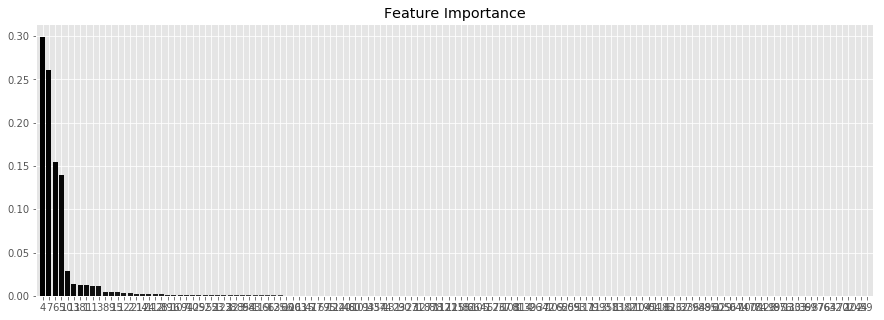

In [53]:
importances = rf_reg.feature_importances_
features = df_train_with_dummies.drop(['visitors','air_area_name_-1'],axis=1).columns
indices = np.argsort(importances)[::-1]
# Plot the feature importancies of the forest
num_to_plot = len(features)
feature_indices = [ind+1 for ind in indices[:num_to_plot]]

# Print the feature ranking
print("Feature ranking:")
  
for f in range(num_to_plot):
    print("%d. %s %f " % (f + 1, 
            features[f], 
            importances[indices[f]]))
plt.figure(figsize=(15,5))
plt.title(u"Feature Importance")
bars = plt.bar(range(num_to_plot), 
               importances[indices[:num_to_plot]],
       color=([str(i/float(num_to_plot+1)) 
               for i in range(num_to_plot)]),
               align="center")
ticks = plt.xticks(range(num_to_plot), 
                   feature_indices)
plt.xlim([-1, num_to_plot])
plt.legend(bars, [features[i]
                  for i in feature_indices]);

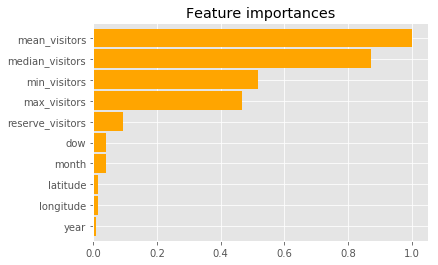

In [94]:
(pd.Series(rf_reg.feature_importances_[0:10],index=features[:10]).sort_values(ascending=True)/np.max(rf_reg.feature_importances_)).plot.barh(color='orange',width=0.9)
_ = plt.title('Feature importances')

### Model with top ten features

In [97]:
y = np.log1p(df_train_with_dummies['visitors']).values
X = df_train_with_dummies.drop(['visitors','air_area_name_-1'],axis=1)
X = X[['year','mean_visitors','median_visitors','min_visitors','max_visitors','reserve_visitors','dow','month','latitude','longitude']].values

In [98]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)
rf_reg = RandomForestRegressor(n_estimators= 100, max_depth=15,max_features=10, min_samples_leaf=1, random_state=42, 
                             n_jobs=-1, oob_score=True)
rf_reg.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features=10, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=True, random_state=42,
           verbose=0, warm_start=False)

In [99]:
y_pred_rf_reg = rf_reg.predict(X_test)

In [100]:
rmse = np.sqrt(mean_squared_error(y_pred_rf_reg,y_test))
print("RMSE",rmse)
print(max(y_pred_rf_reg))
#print(y_pred)

RMSE 0.505608010756
5.08287270487


#### Using XG Boosting

In [54]:
from xgboost import XGBRegressor

C:\Users\nisha\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [55]:
model_xgb = XGBRegressor(n_estimators=100,learning_rate=0.2)
model_xgb.fit(X_train,y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.2, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [56]:
y_pred_xgb = model_xgb.predict(X_test)

In [57]:
rmse = np.sqrt(mean_squared_error(y_pred_xgb,y_test))
print("RMSE",rmse)
print(max(y_pred_xgb))
#print(y_pred)

RMSE 0.505599414948
4.89676


In [58]:
y_pred_xgb = model_xgb.predict(df_test_with_dummies.drop(['visitors'],axis=1).values)
df_test['visitors'] = np.expm1(y_pred_xgb)
df_test[['id','visitors']].to_csv('BaseLine_2_dtree_with_xgb.csv',index=False)

In [44]:
df_test['visitors'] = np.expm1((y_final_pred_rf_reg + y_pred_xgb)/2)
df_test[['id','visitors']].to_csv('BaseLine_2_ensemble.csv',index=False)

By using both Random Forest Regressor and XG Boost the rmse value for test set is similar which is around 0.51